<a href="https://colab.research.google.com/github/glycodynamics/MSAnalyzer/blob/main/analyz_proteins_np_v3_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Program Description: Mass Spectrometry Data Analysis for Replicates**

This Python program, authored by Sushil Mishra (sushilkmishra_at_gmail.com), is designed to facilitate the analysis of mass spectrometry data. The program's primary purpose is to process mul
tiple replicates of serum and sample data obtained from mass spectrometry experiments.

I t's important to exercise caution and ensure the accuracy of its results. To mitigate potential errors and discrepancies, we strongly advise researchers to perform manual verification for  a couple of samples before fully relying on the program's output.


In [ ]:
# @title
# Step 1
from google.colab import drive
from google.colab import files
from google.colab import output
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.core.fromnumeric import std
import warnings
# Disable the warning
warnings.simplefilter("ignore")

pd.ExcelWriter.engine = 'openpyxl'

ref_UniProtID = 'P00761'

# Check if running in Google Colab
try:
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # Mount Google Drive in Colab
    drive.mount('/content/drive')
    data_dir = '/content/drive/My Drive/nanoparticles'
else:
    # Set data_dir to current working directory
    data_dir = os.getcwd()

# No change from here after
serum_dir = os.path.join(data_dir, 'serum')
sample_dir = os.path.join(data_dir, 'sample')

#file_list = os.listdir(data_dir)
#for file_name in file_list:
#    print(file_name)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title
# Check if the directory exists
if os.path.exists(data_dir) and os.path.isdir(data_dir):
    # Get a list of files in the directory
    file_list = os.listdir(data_dir)
else:
    # Display a pop-up message
    message = "The following directories do not exist: " + ", ", data_dir
    output.eval_js(f'alert("{message}")')

if os.path.exists(serum_dir) and os.path.isdir(serum_dir):
    # Get a list of files in the directory
    file_list = os.listdir(serum_dir)
else:
    # Display a pop-up message
    message = "The following directories do not exist: " + ", ", serum_dir
    output.eval_js(f'alert("{message}")')

if os.path.exists(sample_dir) and os.path.isdir(sample_dir):
    # Get a list of files in the directory
    file_list = os.listdir(sample_dir)
else:
    # Display a pop-up message
    message = "The following directories do not exist: " + ", ", sample_dir
    output.eval_js(f'alert("{message}")')

In [ ]:
# @title
# Step 2

# Check if the directory exists
if os.path.exists(sample_dir) and os.path.isdir(sample_dir):
    # Get a list of files in the directory
    file_list = os.listdir(sample_dir)

    # Print the names of the files
    for file_name in file_list:
        print(file_name + "  file found ...")
else:
    print("The specified directory does not exist.")

2HA12-B.xlsx  file found ...
2HA12-A.xlsx  file found ...
2BE-C.xlsx  file found ...
2BE-B.xlsx  file found ...
Bare-B.xlsx  file found ...
2BE-A.xlsx  file found ...
Bare-C.xlsx  file found ...
BA-B.xlsx  file found ...
BA-A.xlsx  file found ...
07-26-Serum-C.xlsx  file found ...
07-26-Serum-B.xlsx  file found ...
07-26-Serum-A.xlsx  file found ...
3HE-C.xlsx  file found ...
3HE-B.xlsx  file found ...
3HE-A.xlsx  file found ...
3HE12-C.xlsx  file found ...
3HE12-B.xlsx  file found ...
3HE12-A.xlsx  file found ...
3BE-C.xlsx  file found ...
3BE-B.xlsx  file found ...
3BE-A.xlsx  file found ...
2HE-C.xlsx  file found ...
2HE-B.xlsx  file found ...
2HE-A.xlsx  file found ...
2HA12-C.xlsx  file found ...


Read all the xlsx files located within the "serum" directory and store their contents in the merged_df DataFrame. This section of the program writes a file named "serum-out.csv" in the "data" directory, containing the total intensity and normalized intensity of all the UniProt IDs present in the data.

In [ ]:
# @title
"""
Read all the xlsx files located within the "serum" directory and store their contents in the merged_df DataFrame.
This section of the program writes a file named "serum-out.csv" in the "data" directory, containing the total intensity
and normalized intensity of all the UniProt IDs present in the data.
"""
ref_UniProtID = 'P00761'
def filter_df(input_df, ref_UniProtID):
    # Define column numbers
    col_log_prob = 2  # Column C
    col_unique_peptides = 7  # Column H

    # Define conditions of log values etc
    condition_1 = input_df.iloc[:, col_log_prob] >= 4
    condition_2 = input_df.iloc[:, col_unique_peptides] >= 3
    condition_3 = input_df['Total\nIntensity'].notnull()
    condition_4 = input_df['Description'].str.contains(ref_UniProtID, case=False, na=False)
    # Combine conditions using logical AND (&)
    combined_condition = condition_4 | (condition_1 & condition_2 & condition_3)
#    print(condition_4)
    # Apply the combined condition to filter the DataFrame
    filtered_df = input_df[combined_condition]
    return filtered_df

In [ ]:
# @title
# Define a function to split the description
def fetch_uniprotid(description):
    parts = description.split("|")
    if len(parts) > 1:
        return parts[1]
    else:
        first_word = description.split()[0]
        # Remove non-alphanumeric characters
        clean_word = re.sub(r'[^A-Za-z0-9]', '', first_word)
        return clean_word


In [ ]:
# @title
def read_and_normalize_serum_files(serum_dir, ref_UniProtID):
  # read all input files inside direcotry serum
  serum_files = glob.glob(os.path.join(serum_dir, "*.xlsx"))
#  serum_files = os.glob.glob(os.path.join(serum_dir, "*.xlsx"))
  merged_df = pd.DataFrame()
  i = 1
  for f in serum_files:
    fname = f.split("/")[-1][:-5]
    tmp_df = pd.read_excel(f, sheet_name='Proteins')
    df = filter_df(tmp_df,ref_UniProtID)
    short_df = pd.DataFrame({'Description': df['Description'].apply(fetch_uniprotid), 'Total Intensity': df['Total\nIntensity']})
    # Read intensity of the row corresponding to Trypsin UniProt ID iput as "ref_UNIProtID"
    ref_TotIntensity = short_df.loc[short_df['Description'] == ref_UniProtID, 'Total Intensity'].values[0]
    short_df [f'Normalized Intensity {fname}'] = short_df['Total Intensity'] / ref_TotIntensity
    short_df = short_df.rename(columns={'Total Intensity': f'Total Intensity {fname}'})

 #   rename columd to 'Total Intensity Serum-1'	amd 'Normalized Intensity Serum-1'
    globals()[f'short_df_{i}'] = short_df.copy()
    if i == 1:
      merged_df = globals()[f'short_df_{i}']
    if i >= 2:
      merged_df = merged_df.merge(globals()[f'short_df_{i}'], on='Description', how='outer')
    i = i + 1

# Calculate mean of Normalized Intensity rows for all the samples..
  normalized_columns = [col for col in merged_df.columns if col.startswith("Normalized Intensity")]
  merged_df['Mean Normalized Intensity'] = merged_df[normalized_columns].mean(axis=1)
  merged_df['Stdev Normalized Intensity'] = merged_df[normalized_columns].std(axis=1)
  merged_df = merged_df[merged_df[normalized_columns].notna().sum(axis=1) >= 2]
# print(average_normalized)
  return merged_df


# call the function read_and_normalize_xlsx_files
serum_df = read_and_normalize_serum_files(serum_dir, 'P00761')
mean_serum_df = serum_df[['Description', 'Mean Normalized Intensity']]
output_path = os.path.join(data_dir, 'serum-out.xlsx')
serum_df.to_excel(output_path, index=False)

In [ ]:
# new one
import sys  # Import the sys module to exit the program
def read_and_normalize_sample_file(sample_dir, sfile, ref_UniProtID, mean_serum_df):
    """
    Calculate mean and standard deviation of normalized intensities for replicate samples.
    :param replicate_file1: Path to the first replicate Excel file.
    :param trypsin_uniprot_id: UniProt ID of Trypsin.
    :param serum_intensity_df: DataFrame containing normalized serum intensities.
    :return: Mean and standard deviation of normalized intensities.
    """
    RelNorInt_df = pd.DataFrame()
    # Return calculated mean and standard deviation  for f in serum_files:
    fname = sfile.split("/")[-1][:-5]
    parts = re.split(r'[-\s]+', fname)
    sample_name = parts[-2]
    replicate = parts[-1]
    sample_replicate=sample_name+"-"+replicate

    sample_file = os.path.join(sample_dir, sfile)
    df_tmp = pd.read_excel(sample_file, sheet_name='Proteins')
    df = filter_df(df_tmp, ref_UniProtID)
    short_df = pd.DataFrame({'Description': df['Description'].apply(fetch_uniprotid), 'Total Intensity': df['Total\nIntensity']})
    # Check if ref_UniProtID is present in the 'Description' column
    if ref_UniProtID not in short_df['Description'].values:
      print(f"Error: ref_UniProtID '{ref_UniProtID}' not found in", sfile, "FIX THIS ERROR!")
      sys.exit()  # Exit the program

    ref_TotIntensity = short_df.loc[short_df['Description'] == ref_UniProtID, 'Total Intensity'].values[0]

    short_df ['Normalized Intensity'] = short_df['Total Intensity'] / ref_TotIntensity
    #    short_df = short_df.rename(columns={'Total Intensity': f'Total Intensity {fname}'})
    RelNorInt_df = pd.merge(short_df, mean_serum_df, on='Description', how='left')
    RelNorInt_df.rename(columns={'Mean Normalized Intensity': 'Mean_Norm_Serum_Int'}, inplace=True)
    RelNorInt_df['Relative Normalized Intensity'] = RelNorInt_df['Normalized Intensity'] / RelNorInt_df['Mean_Norm_Serum_Int']
    NorInt_df = short_df
    columns_to_drop = ['Total Intensity', 'Normalized Intensity', 'Mean_Norm_Serum_Int']
    RelNorInt_df = RelNorInt_df.drop(columns=columns_to_drop)
    RelNorInt_df = RelNorInt_df.rename(columns={'Relative Normalized Intensity': f' Rel_Nor_Int {sample_replicate}'})

    # rename the columns from Total Intensity to TotInt_sample_replicate, Normalized Intensity to Norm_INT
    NorInt_df = NorInt_df.rename(columns={'Total Intensity': f' Tot_Int {sample_replicate}'})
    NorInt_df = NorInt_df.rename(columns={'Normalized Intensity': f' Nor_Int {sample_replicate}'})

    return RelNorInt_df, NorInt_df

# call the function read_and_normalize_xlsx_files
#RelNorInt_df, NorInt_df = read_and_normalize_sample_file(sample_dir, "HPA-C.xlsx", 'P00761', mean_serum_df )
#NorInt_df

In [ ]:
# This code reads all the files placed inside sample directory and stores sample_names and replicates
# new one
sample_files = os.listdir(sample_dir)

# Initialize the merged NorInt dataframe
merged_NorInt_df = pd.DataFrame()
merged_TotInt_df = pd.DataFrame()

# Extract unique sample names and replicates
sample_names = set()
replicates = set()

i=1
for file_name in sample_files:
#    parts = os.path.splitext(file_name)[0].split('-')
    parts = re.split(r'[-\s]+', file_name)
    if len(parts) >= 2:
      sample_name = parts[-2]
      replicate = parts[-1]
      sample_names.add(sample_name)
      replicates.add(replicate)
      sample_replicate=sample_name+"-"+replicate
      print("Reading ....", file_name)
      RelNorInt_df, NorInt_df = read_and_normalize_sample_file(sample_dir, file_name, ref_UniProtID,  mean_serum_df)
      print("Reading ", file_name, "sucessfull!")

 #   rename column to 'Relative Intensity H2-A'	amd 'Normalized Intensity H2B'
    globals()[f'short_df_{sample_replicate}'] = RelNorInt_df.copy()

    if i == 1:
      merged_df = globals()[f'short_df_{sample_replicate}']
      merged_NorInt_df = NorInt_df.iloc[:, [0, 2]].copy()
      merged_TotInt_df = NorInt_df.iloc[:, [0, 1]].copy()

    if i >= 2:
      merged_df = merged_df.merge(globals()[f'short_df_{sample_replicate}'], on='Description', how='outer')
      merged_NorInt_df = pd.merge(merged_NorInt_df, NorInt_df.iloc[:, [0, 2]], on="Description", how="outer")
      merged_TotInt_df = pd.merge(merged_TotInt_df, NorInt_df.iloc[:, [0, 1]], on="Description", how="outer")

    i = i + 1

merge_serum_sample = pd.merge(mean_serum_df, merged_TotInt_df, on="Description", how="outer")
merge_serum_sample = pd.merge(merge_serum_sample, merged_NorInt_df, on="Description", how="outer")
merge_serum_sample = pd.merge(merge_serum_sample, merged_df, on="Description", how="outer")



# Path to the output Excel file
merge_serum_sample.rename(columns={'Mean Normalized Intensity': 'Serum_Nor_Int'}, inplace=True)
merge_serum_sample

Reading .... 2HA12-B.xlsx
Reading  2HA12-B.xlsx sucessfull!
Reading .... 2HA12-A.xlsx
Reading  2HA12-A.xlsx sucessfull!
Reading .... 2BE-C.xlsx
Reading  2BE-C.xlsx sucessfull!
Reading .... 2BE-B.xlsx
Reading  2BE-B.xlsx sucessfull!
Reading .... Bare-B.xlsx
Reading  Bare-B.xlsx sucessfull!
Reading .... 2BE-A.xlsx
Reading  2BE-A.xlsx sucessfull!
Reading .... Bare-C.xlsx
Reading  Bare-C.xlsx sucessfull!
Reading .... BA-B.xlsx
Reading  BA-B.xlsx sucessfull!
Reading .... BA-A.xlsx
Reading  BA-A.xlsx sucessfull!
Reading .... 07-26-Serum-C.xlsx
Reading  07-26-Serum-C.xlsx sucessfull!
Reading .... 07-26-Serum-B.xlsx
Reading  07-26-Serum-B.xlsx sucessfull!
Reading .... 07-26-Serum-A.xlsx
Reading  07-26-Serum-A.xlsx sucessfull!
Reading .... 3HE-C.xlsx
Reading  3HE-C.xlsx sucessfull!
Reading .... 3HE-B.xlsx
Reading  3HE-B.xlsx sucessfull!
Reading .... 3HE-A.xlsx
Reading  3HE-A.xlsx sucessfull!
Reading .... 3HE12-C.xlsx
Reading  3HE12-C.xlsx sucessfull!
Reading .... 3HE12-B.xlsx
Reading  3HE12-B.x

,Description,Serum_Nor_Int,Tot_Int 2HA12-B,Tot_Int 2HA12-A,Tot_Int 2BE-C,Tot_Int 2BE-B,Tot_Int Bare-B,Tot_Int 2BE-A,Tot_Int Bare-C,Tot_Int BA-B,...,Rel_Nor_Int 3HE12-C,Rel_Nor_Int 3HE12-B,Rel_Nor_Int 3HE12-A,Rel_Nor_Int 3BE-C,Rel_Nor_Int 3BE-B,Rel_Nor_Int 3BE-A,Rel_Nor_Int 2HE-C,Rel_Nor_Int 2HE-B,Rel_Nor_Int 2HE-A,Rel_Nor_Int 2HA12-C
0,P07724,122.198729,1.811001e+10,1.124692e+10,3.081213e+10,1.831242e+10,5.585428e+09,1.938446e+10,6.523433e+09,1.948005e+10,...,0.883647,1.114483,1.664655,1.108669,3.021873,1.594291,0.727492,0.558143,1.372813,7.080391
1,Q921I1,25.062529,3.875564e+09,1.919334e+09,7.353457e+09,2.745490e+09,8.564648e+08,5.219005e+09,5.886460e+08,4.047483e+09,...,0.827150,0.640424,2.275259,1.306884,3.020353,1.792849,0.662103,0.568541,1.086237,4.589553
2,A0A075B5P4,2.265324,2.455160e+08,1.954636e+08,8.571230e+08,2.109358e+08,5.432493e+07,NaN,2.876154e+07,2.484259e+08,...,0.453235,0.595531,1.051200,1.587792,2.485827,2.259159,0.729823,0.754030,0.930113,3.998720
3,Q61838,1.939423,6.422883e+08,2.561757e+08,1.038668e+09,2.425210e+08,1.006636e+08,2.750097e+08,3.344418e+07,5.424922e+08,...,1.047240,0.798253,1.291933,3.550863,4.702908,4.832205,0.920428,0.564522,1.779488,3.282454
4,P01027,0.942668,3.218087e+08,1.089571e+08,5.611593e+08,1.428464e+08,3.977166e+07,1.218390e+08,1.673558e+07,2.566148e+08,...,1.218062,0.527238,0.962657,3.507007,5.595357,3.683687,0.973702,0.675226,1.881909,2.231472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,G3X977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,P29788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,P01898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,A0A075B5R9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# @title
def calculate_mean_std(merged_df, sample_names):
    mean_result = pd.DataFrame()
    std_result = pd.DataFrame()
    i = 1
    for sample_name in sample_names:
        sample_name_df = merged_df.filter(items=['Description'] + [col for col in merged_df.columns if sample_name in col])
        subset_columns = sample_name_df.columns.difference(['Description'])
        filtered_df = sample_name_df.dropna(subset=subset_columns, thresh=2)
        # Calculate Mean and Std using .assign() to create new columns
        filtered_df = filtered_df.assign(Mean=filtered_df[subset_columns].mean(axis=1))
        filtered_df = filtered_df.assign(Mean10=np.log10(filtered_df[subset_columns]).mean(axis=1))
        filtered_df = filtered_df.assign(Mean2=np.log2(filtered_df[subset_columns]).mean(axis=1))

        filtered_df = filtered_df.assign(Std=filtered_df[subset_columns].std(axis=1))
        filtered_df = filtered_df.assign(Std10=np.log10(filtered_df[subset_columns]).std(axis=1))
        filtered_df = filtered_df.assign(Std2=np.log2(filtered_df[subset_columns]).std(axis=1))
#        print(np.log10(filtered_df[subset_columns]))

        mean_int_df = filtered_df[['Description', 'Mean']].copy()
        mean10_int_df = filtered_df[['Description', 'Mean10']].copy()
        mean2_int_df = filtered_df[['Description', 'Mean2']].copy()

        std_int_df = filtered_df[['Description', 'Std']].copy()
        std10_int_df = filtered_df[['Description', 'Std10']].copy()
        std2_int_df = filtered_df[['Description', 'Std2']].copy()

        mean_int_df.rename(columns={'Mean': sample_name}, inplace=True)
        mean10_int_df.rename(columns={'Mean10': sample_name}, inplace=True)
        mean2_int_df.rename(columns={'Mean2': sample_name}, inplace=True)


        std_int_df.rename(columns={'Std': sample_name}, inplace=True)
        std10_int_df.rename(columns={'Std10': sample_name}, inplace=True)
        std2_int_df.rename(columns={'Std2': sample_name}, inplace=True)

        if i == 1:
            mean_result = mean_int_df
            mean10_result = mean10_int_df
            mean2_result = mean2_int_df

            std_result = std_int_df
            std10_result = std10_int_df
            std2_result = std2_int_df
        else:
            mean_result = pd.merge(mean_result, mean_int_df, on='Description', how='left')
            mean10_result = pd.merge(mean10_result, mean10_int_df, on='Description', how='left')
            mean2_result = pd.merge(mean2_result, mean2_int_df, on='Description', how='left')

            std_result = pd.merge(std_result, std_int_df, on='Description', how='left')
            std10_result = pd.merge(std10_result, std10_int_df, on='Description', how='left')
            std2_result = pd.merge(std2_result, std2_int_df, on='Description', how='left')
        i = i + 1
    #print(mean10_result)
    return mean_result, mean10_result, mean2_result, std_result, std10_result, std2_result

# Call the function with your merged_df and sample_names
mean_result, mean10_result, mean2_result, std_result, std10_result, std2_result = calculate_mean_std(merged_df, sample_names)

# Define a function to take the log10 of numeric values and leave non-numeric values unchanged


# Export mean_result to "Mean" tab and std_result to "STDEV" tab in sample.csv
mean_std_result = pd.concat([mean_result, pd.DataFrame(columns=['', '']), std_result], axis=1)
mean_std10_result = pd.concat([mean10_result, pd.DataFrame(columns=['', '']), std10_result], axis=1)
mean_std2_result = pd.concat([mean2_result, pd.DataFrame(columns=['', '']), std2_result], axis=1)

#mean_std_result = pd.merge(mean_result, std_result, on="Description", suffixes=("_mean", "_std"))

# Create a Pandas Excel writer using openpyxl as the engine and the existing workbook


# Export mean_result to "Mean" tab and std_result to "STDEV" tab in sample.csv
output_sample_path = os.path.join(data_dir, 'sample-out.xlsx')

#excel_writer.save()
with pd.ExcelWriter(output_sample_path) as writer:
  merge_serum_sample.to_excel(writer, sheet_name='Sample_Data')
  mean_std_result.to_excel(writer, sheet_name='Av_Std_Int')
  mean_std10_result.to_excel(writer, sheet_name='Av_Std_log10_Int')
  mean_std2_result.to_excel(writer, sheet_name='Av_Std_log2_Int')



#excel_writer.save()
#with pd.ExcelWriter(output_sample_path) as writer:
#  mean_result.to_excel(writer, sheet_name='Mean_Int')
#  std_result.to_excel(writer, sheet_name='Std_Int')

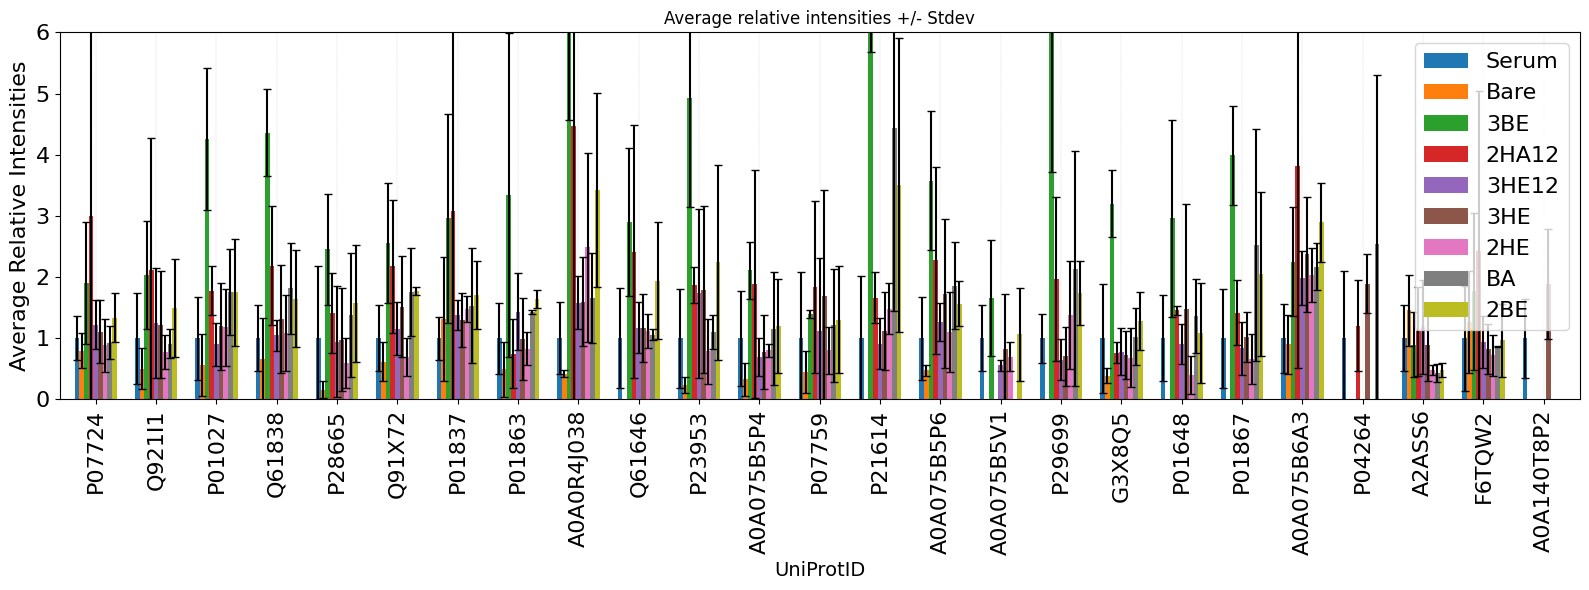

In [ ]:
# @title
# Plot absolute values
mean_result, mean10_result, mean2_result, std_result, std10_result, std2_result = calculate_mean_std(merged_df, sample_names)
#mean_result, std_result = calculate_mean_std(merged_df, sample_names)
mean_result = mean_result[~mean_result['Description'].str.contains(ref_UniProtID)]
std_result = std_result[~std_result['Description'].str.contains(ref_UniProtID)]

# Assuming you have your dataframes mean_result, std_result, and sample_names defined
# mean_result, std_result = calculate_mean_std(merged_df, sample_names)

# Set the Description column as the index for plotting
mean_result.set_index('Description', inplace=True)
std_result.set_index('Description', inplace=True)

# Calculate the log10 of the dataframe values
log_mean_result = (mean_result)

# Calculate the log10 of the standard deviation values
log_std_result = abs((std_result))
# Plotting
plt.figure(figsize=(16, 6))  # Adjust the figure size as needed
ax = log_mean_result.plot(kind='bar', ax=plt.gca(), yerr=log_std_result.values.T, capsize=3, width=0.7)  # Transpose yerr for correct shape
ax.set_xlabel('Description', horizontalalignment='center', fontsize=16)

# Place the legend in a single row at the bottom
ax.legend(loc='upper right', fontsize = 16)

ax.set_xticklabels(log_mean_result.index, rotation=90, ha='center', fontsize=16)  # Rotating x-axis labels for readability
plt.yticks(fontsize=16)
plt.title("Average relative intensities +/- Stdev")
ax.set_xlabel('UniProtID', fontsize=14)
ax.set_ylabel('Average Relative Intensities', fontsize=16)
ax.set_ylim(0, 6)  # Set y-axis range from -4 to 4
ax.grid(axis = 'x',linewidth = 0.2, linestyle = ':', color = 'gray')
# Display the plot
plt.tight_layout()
# Save the plot to a file
plot_filename = os.path.join(data_dir, 'plot_av_mean.png')
plt.savefig(plot_filename, dpi=300)
plt.show()


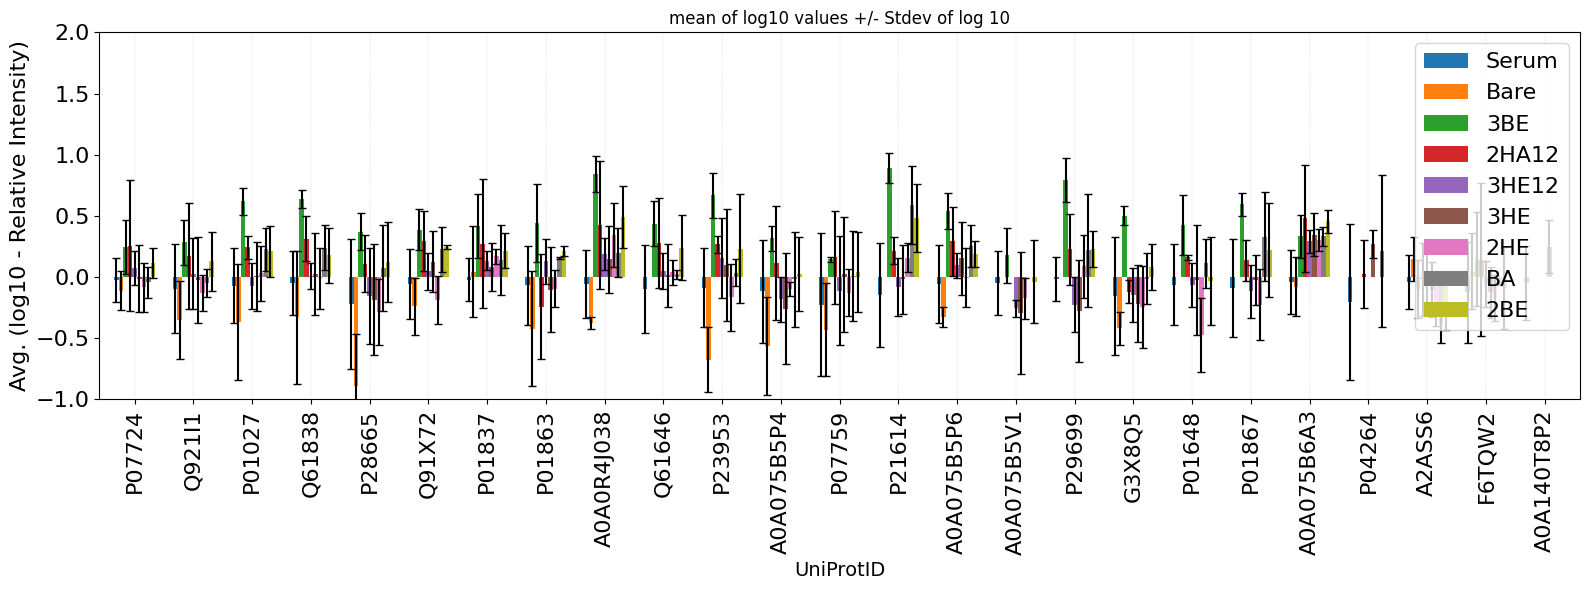

In [ ]:
# @title
# Plot mean Log10 values #new
mean_result, mean10_result, mean2_result, std_result, std10_result, std2_result = calculate_mean_std(merged_df, sample_names)
#mean_result, std_result = calculate_mean_std(merged_df, sample_names)
mean10_result = mean10_result[~mean10_result['Description'].str.contains(ref_UniProtID)]
std10_result = std10_result[~std10_result['Description'].str.contains(ref_UniProtID)]

# Assuming you have your dataframes mean_result, std_result, and sample_names defined
# mean_result, std_result = calculate_mean_std(merged_df, sample_names)

# Set the Description column as the index for plotting
mean10_result.set_index('Description', inplace=True)
std10_result.set_index('Description', inplace=True)

# Calculate the log10 of the dataframe values
#log_mean_result = np.log10(mean_result)
log_mean_result = mean10_result

# Calculate the log10 of the standard deviation values
log_std_result = abs(std10_result)
# Plotting
plt.figure(figsize=(16, 6))  # Adjust the figure size as needed
ax = log_mean_result.plot(kind='bar', ax=plt.gca(), yerr=log_std_result.values.T, capsize=3, width=0.7)  # Transpose yerr for correct shape
ax.set_xlabel('Description', horizontalalignment='center', fontsize=16)

# Place the legend in a single row at the bottom
ax.legend(loc='upper right', fontsize = 16)

ax.set_xticklabels(log_mean_result.index, rotation=90, ha='center', fontsize=16)  # Rotating x-axis labels for readability
plt.yticks(fontsize=16)
plt.title("mean of log10 values +/- Stdev of log 10")
ax.set_xlabel('UniProtID', fontsize=14)
ax.set_ylabel('Avg. (log10 - Relative Intensity)', fontsize=16)
ax.set_ylim(-1, 2)  # Set y-axis range from -4 to 4
ax.grid(axis = 'x',linewidth = 0.2, linestyle = ':', color = 'gray')
# Display the plot
plt.tight_layout()
# Save the plot to a file
plot_filename = os.path.join(data_dir, 'plot_mean_of_log10.png')
plt.savefig(plot_filename, dpi=300)
plt.show()


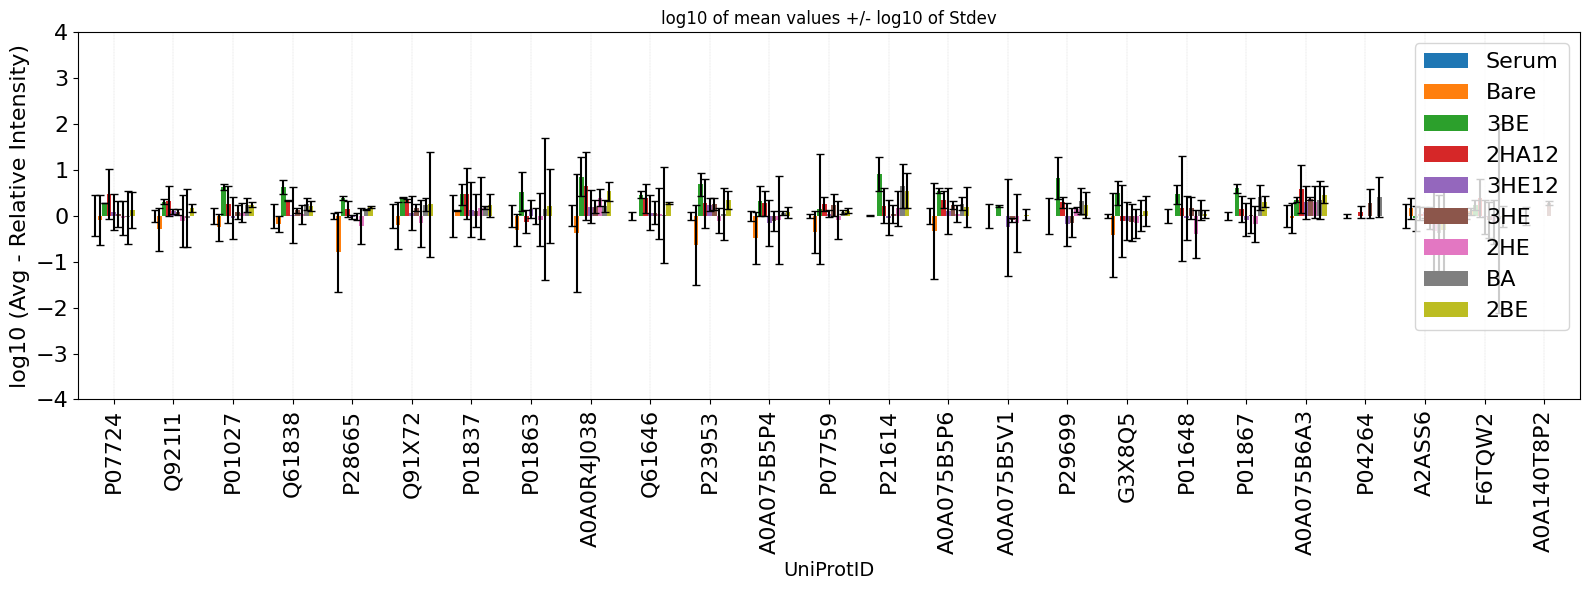

In [ ]:
# @title
# Plot Log10 - old
mean_result, mean10_result, mean2_result, std_result, std10_result, std2_result = calculate_mean_std(merged_df, sample_names)
#mean_result, std_result = calculate_mean_std(merged_df, sample_names)
mean_result = mean_result[~mean_result['Description'].str.contains(ref_UniProtID)]
std_result = std_result[~std_result['Description'].str.contains(ref_UniProtID)]

# Assuming you have your dataframes mean_result, std_result, and sample_names defined
# mean_result, std_result = calculate_mean_std(merged_df, sample_names)

# Set the Description column as the index for plotting
mean_result.set_index('Description', inplace=True)
std_result.set_index('Description', inplace=True)

# Calculate the log10 of the dataframe values
#log_mean_result = np.log10(mean_result)
log_mean_result = np.log10(mean_result)

# Calculate the log10 of the standard deviation values
log_std_result = abs(np.log10(std_result))
# Plotting
plt.figure(figsize=(16, 6))  # Adjust the figure size as needed
ax = log_mean_result.plot(kind='bar', ax=plt.gca(), yerr=log_std_result.values.T, capsize=3, width=0.7)  # Transpose yerr for correct shape
ax.set_xlabel('Description', horizontalalignment='center', fontsize=16)

# Place the legend in a single row at the bottom
ax.legend(loc='upper right', fontsize = 16)

ax.set_xticklabels(log_mean_result.index, rotation=90, ha='center', fontsize=16)  # Rotating x-axis labels for readability
plt.yticks(fontsize=16)
plt.title("log10 of mean values +/- log10 of Stdev")
ax.set_xlabel('UniProtID', fontsize=14)
ax.set_ylabel('log10 (Avg - Relative Intensity)', fontsize=16)
ax.set_ylim(-4, 4)  # Set y-axis range from -4 to 4
ax.grid(axis = 'x',linewidth = 0.2, linestyle = ':', color = 'gray')
# Display the plot
plt.tight_layout()
# Save the plot to a file
plot_filename = os.path.join(data_dir, 'plot_log10_of_mean.png')
plt.savefig(plot_filename, dpi=300)
plt.show()




---


**Program Description: Mass Spectrometry Data Analysis for triplicates**

---

***Data Loading and Processing:***
The program expects the mass spectrometry data to be organized in a specific directory structure. Multiple replicates of serum data should be placed within a directory named "serum", and replicates of different samples should be placed within a directory named "sample". The program then loads and processes the data from these directories, calculated the normalized relative intensities of different proteins and plots them as bar graph.

***Data Analysis and Visualization:***
Once the data is loaded and processed, the program calculates the normalized relative intensities of proteins by comparing the intensities of samples to those of serum. Proteins identified in only one replicate are omitted from calculations. The program then generates a bar plot of the calculated intensities, displaying the log2 or log10 values on the y-axis. Error bars representing the standard deviation in relative intensity across multiple replicates are also included in the plot.

***Usage Instructions:***



*Running in Google Colab:*

Create a directory named "ms_treplicates" in your Google Drive.

1. Upload all your XLSX files to the "ms_treplicates" directory in two separate subdirectories:
* Place the replicate serum XLSX files within the "serum" subdirectory.
* Store all the XLSX files for samples in the "sample" subdirectory.

2. Update the data directory's location by modifying the "data_dir" variable at the beginning of the program.

3. Now, press Ctrl + F9 or click on "Runtime" and then choose "Run all."

4. The program should display bar graphs and generate four files in your data directory:
* `serum-out.xlsx`: This file contains analyzed serum data.
* `sample-out.xlsx`: This file contains analyzed sample data.
* `log2_plot.png`: This is a bar graph displaying log2 values.
* `log10_plot.png`: This is a bar graph displaying log10 values.

*Running Locally in your computer:*

1. Install folloing pythin libraries:
* `os`: Managing directories and files on your computer.
* `re`: Working with text patterns, making it easier to find certain text.
* `glob`: Finding files based on patterns in directories.
* `pandas`: Handling and analyzing data, especially from files like CSVs.
* `numpy`: Doing complex math and working with large datasets.
* `matplotlib.pyplot`: Creating graphs and charts to visualize data.


2. Download the program file by following these steps:
* Click on "File" in the top menu.
* Choose "Download," and then select "Download.py."
* Save the downloaded file inside the data directory where you have the "sample" and "serum" directories.

3. To run the Python program, follow these steps:
***Windows Machine:*** Locate the Download.py file in your data directory.
Double-click on the Download.py file to execute it. The program will start running, performing the required analysis on your data.

***Linux machine:*** Change direcotry to where you have the data and run:
```python3 program_name.py```